In [780]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection

In [777]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [778]:
from path_explain.path_explainer_tf import PathExplainerTF
from path_explain.utils import set_up_environment, softplus_activation
from plot.scatter import _single_scatter, _color_bar, _get_bounds
set_up_environment(visible_devices='0')

In [505]:
x, y = datasets.make_circles(n_samples=1000, factor=0.5, noise=0.15)
y = (y == 0).astype(int)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

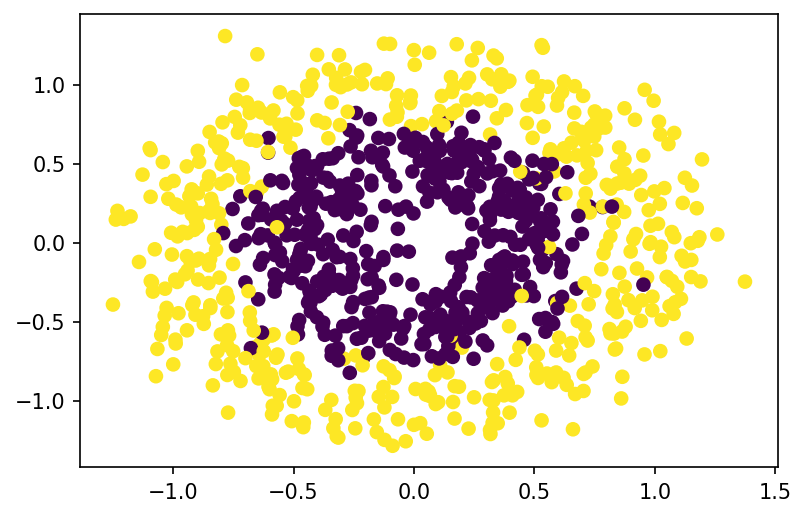

In [506]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=y)

In [676]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(2,))
model.add(tf.keras.layers.Dense(4, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(4, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(1, activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.sigmoid))

In [677]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [678]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=100, epochs=18, verbose=2)

Train on 800 samples, validate on 200 samples
Epoch 1/18
800/800 - 1s - loss: 0.6633 - binary_accuracy: 0.5913 - val_loss: 0.6578 - val_binary_accuracy: 0.6700
Epoch 2/18
800/800 - 0s - loss: 0.6497 - binary_accuracy: 0.7000 - val_loss: 0.6432 - val_binary_accuracy: 0.7300
Epoch 3/18
800/800 - 0s - loss: 0.6327 - binary_accuracy: 0.7225 - val_loss: 0.6244 - val_binary_accuracy: 0.7350
Epoch 4/18
800/800 - 0s - loss: 0.6084 - binary_accuracy: 0.7412 - val_loss: 0.6011 - val_binary_accuracy: 0.7600
Epoch 5/18
800/800 - 0s - loss: 0.5802 - binary_accuracy: 0.7763 - val_loss: 0.5736 - val_binary_accuracy: 0.7650
Epoch 6/18
800/800 - 0s - loss: 0.5447 - binary_accuracy: 0.7987 - val_loss: 0.5393 - val_binary_accuracy: 0.8350
Epoch 7/18
800/800 - 0s - loss: 0.5048 - binary_accuracy: 0.8300 - val_loss: 0.5025 - val_binary_accuracy: 0.8650
Epoch 8/18
800/800 - 0s - loss: 0.4621 - binary_accuracy: 0.8712 - val_loss: 0.4651 - val_binary_accuracy: 0.8750
Epoch 9/18
800/800 - 0s - loss: 0.4193 - b

In [700]:
model_no_sigmoid = tf.keras.models.Model(model.input, model.layers[2].output)

In [701]:
x = np.linspace(-2, 2, 256)
y = np.linspace(-2, 2, 256)

X, Y = np.meshgrid(x, y)
stacked_input = np.stack([X.flatten(), Y.flatten()], axis=1)
model_output  = model_no_sigmoid(stacked_input)
Z = model_output.numpy().reshape(X.shape)

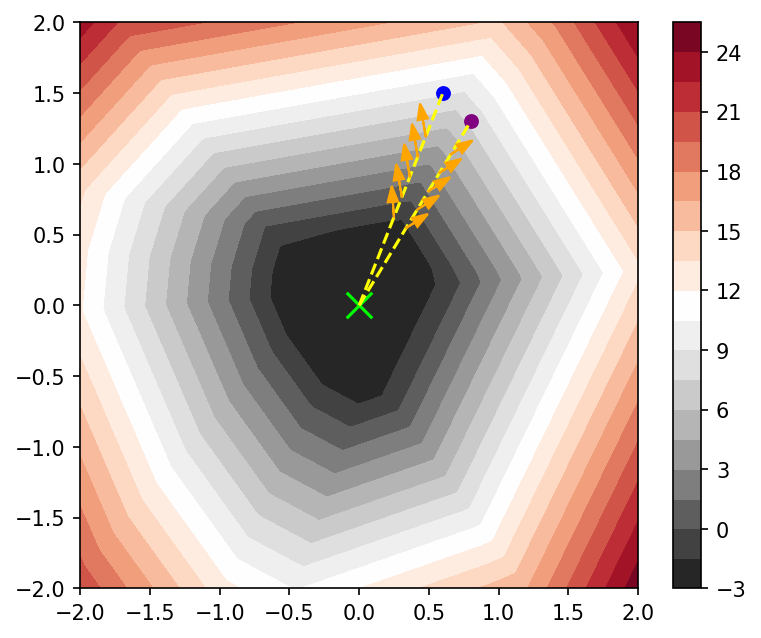

In [702]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, Z, 20, cmap='RdGy_r')
plt.colorbar()
plt.scatter(x=[0.0], y=[0.0], marker='x', s=150, color='lime')

points = np.array([
    [0.6, 1.5],
    [0.8, 1.3]
])

alphas = [
    [0.415, 0.51, 0.605, 0.7, 0.795],
    [0.42, 0.52, 0.62, 0.72, 0.82]
]

colors = ['blue', 'purple']

for i, point in enumerate(points):
    plt.scatter(x=point[0], y=point[1], marker='.', s=150, color=colors[i])
    plt.plot([0.0, point[0]], [0.0, point[1]], linestyle='--', color='yellow')

    gradient_points = []
    for alpha in alphas[i]:
        gradient_points.append([point[0] * alpha, point[1] * alpha])
    gradient_points = np.array(gradient_points)

    gradient_points_tf = tf.convert_to_tensor(gradient_points)
    with tf.GradientTape() as tape:
        tape.watch(gradient_points_tf)
        output = model_no_sigmoid(gradient_points_tf)
    gradients = tape.gradient(output, gradient_points_tf).numpy()

    for index in range(gradient_points.shape[0]):
        x_base = gradient_points[index, 0]
        y_base = gradient_points[index, 1]
        grad_x = gradients[index, 0]
        grad_y = gradients[index, 1]

        grad_magnitude = np.abs(grad_x + grad_y) * 10
        grad_x = grad_x / grad_magnitude
        grad_y = grad_y / grad_magnitude
        plt.arrow(x_base, y_base, grad_x, grad_y, color='orange', head_width=0.075, zorder=5)

In [708]:
softplus_model = tf.keras.models.clone_model(model_no_sigmoid)
softplus_model.set_weights(model_no_sigmoid.get_weights())

In [709]:
for i, layer in enumerate(softplus_model.layers):
    if i < len(softplus_model.layers) - 1:
        layer.activation = softplus_activation(beta=5.0)

In [710]:
softplus_model_output = softplus_model(stacked_input)
softplus_Z = softplus_model_output.numpy().reshape(X.shape)

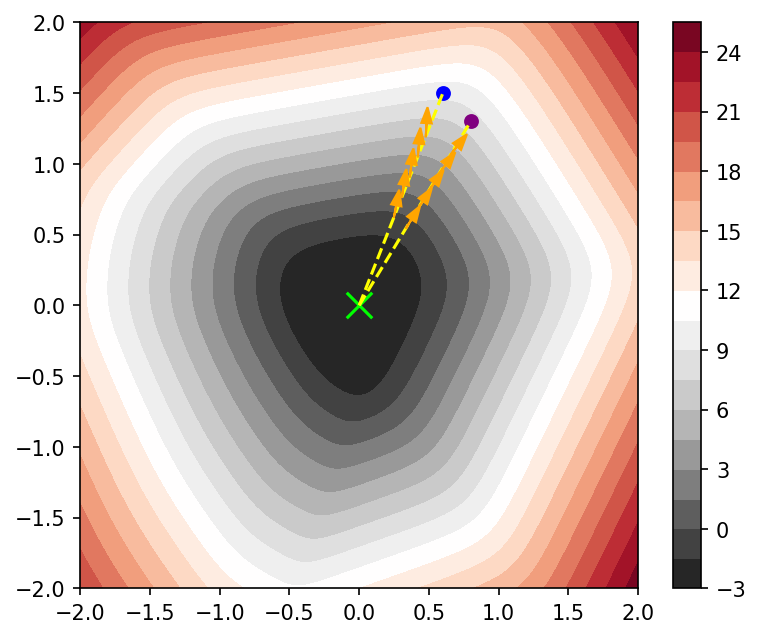

In [713]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, softplus_Z, 20, cmap='RdGy_r')
plt.colorbar()
plt.scatter(x=[0.0], y=[0.0], marker='x', s=150, color='lime')

points = np.array([
    [0.6, 1.5],
    [0.8, 1.3]
])

alphas = [
    [0.415, 0.51, 0.605, 0.7, 0.795],
    [0.42, 0.52, 0.62, 0.72, 0.82]
]

colors = ['blue', 'purple']

for i, point in enumerate(points):
    plt.scatter(x=point[0], y=point[1], marker='.', s=150, color=colors[i])
    plt.plot([0.0, point[0]], [0.0, point[1]], linestyle='--', color='yellow')

    gradient_points = []
    for alpha in alphas[i]:
        gradient_points.append([point[0] * alpha, point[1] * alpha])
    gradient_points = np.array(gradient_points)

    gradient_points_tf = tf.convert_to_tensor(gradient_points)
    with tf.GradientTape() as tape:
        tape.watch(gradient_points_tf)
        with tf.GradientTape() as second_tape:
            second_tape.watch(gradient_points_tf)
            output = softplus_model(gradient_points_tf)
        gradients = second_tape.gradient(output, gradient_points_tf)
    hessians  = tape.jacobian(gradients, gradient_points_tf).numpy()
    gradients = gradients.numpy()

    for index in range(gradient_points.shape[0]):
        x_base = gradient_points[index, 0]
        y_base = gradient_points[index, 1]
        grad_x = gradients[index, 0]
        grad_y = gradients[index, 1]

        grad_magnitude = np.abs(grad_x + grad_y) * 10
        grad_x = grad_x / grad_magnitude
        grad_y = grad_y / grad_magnitude

        hess_xx = hessians[index, 0, index, 0]
        hess_xy = hessians[index, 0, index, 1]
        hess_yy = hessians[index, 1, index, 1]
        plt.arrow(x_base, y_base, grad_x, grad_y, color='orange', head_width=0.075, zorder=5)

In [731]:
explainer = PathExplainerTF(model_no_sigmoid)

In [733]:
softplus_explainer = PathExplainerTF(softplus_model)

In [793]:
attributions = explainer.attributions(x_train.astype(np.float32),
                                      baseline=np.zeros((1, 2)).astype(np.float32),
                                      batch_size=100,
                                      num_samples=100,
                                      use_expectation=False,
                                      output_indices=0,
                                      verbose=True)
interactions = explainer.interactions(x_train.astype(np.float32),
                                      baseline=np.zeros((1, 2)).astype(np.float32),
                                      batch_size=100,
                                      num_samples=100,
                                      use_expectation=False,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 800/800 [01:07<00:00, 11.79it/s]


In [794]:
softplus_attributions = softplus_explainer.attributions(x_train.astype(np.float32),
                                      baseline=np.zeros((1, 2)).astype(np.float32),
                                      batch_size=100,
                                      num_samples=100,
                                      use_expectation=False,
                                      output_indices=0,
                                      verbose=False)
softplus_interactions = softplus_explainer.interactions(x_train.astype(np.float32),
                                      baseline=np.zeros((1, 2)).astype(np.float32),
                                      batch_size=100,
                                      num_samples=100,
                                      use_expectation=False,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 800/800 [06:42<00:00,  1.99it/s]


In [795]:
def plot_axis(ax, x, y, c, **kwargs):
    vmin, vmax = _get_bounds(c)
    c = np.clip(c, vmin, vmax)
    data = pd.DataFrame({
        'x': x,
        'y': y,
        'c': c
    })
    _single_scatter(ax, data, 'x', 'y', 'c', (-1.5, 1.5), (-1.5, 1.5), **kwargs)

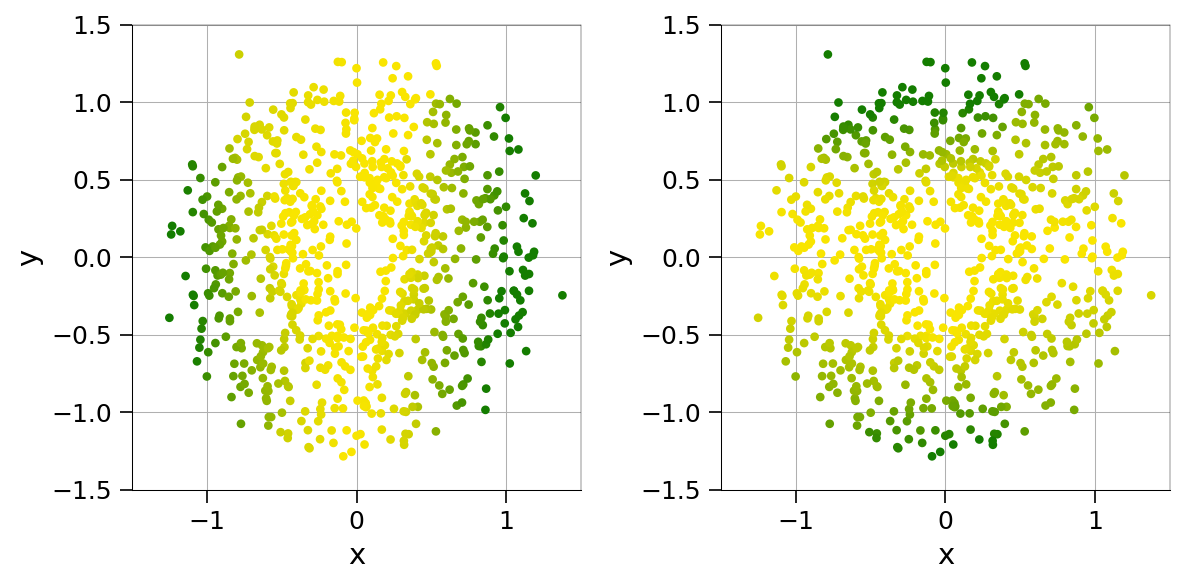

In [797]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plot_axis(ax=axs[0], x=x_train[:, 0], y=x_train[:, 1], c=attributions[:, 0], s=10)
plot_axis(ax=axs[1], x=x_train[:, 0], y=x_train[:, 1], c=attributions[:, 1], s=10)
fig.tight_layout()

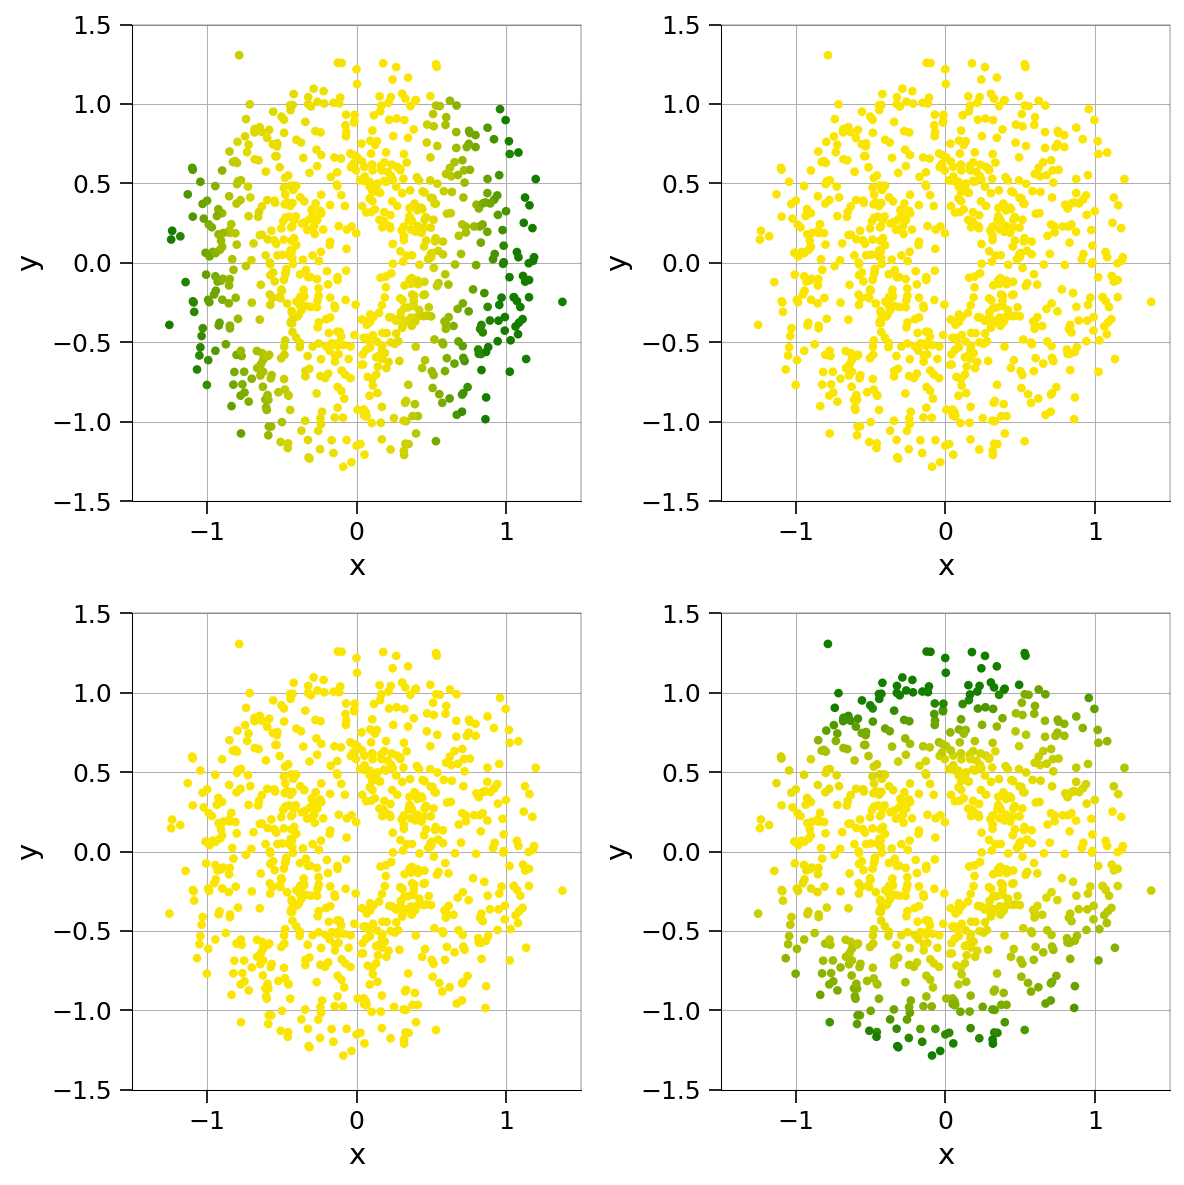

In [798]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plot_axis(ax=axs[0, 0], x=x_train[:, 0], y=x_train[:, 1], c=interactions[:, 0, 0], s=10)
plot_axis(ax=axs[0, 1], x=x_train[:, 0], y=x_train[:, 1], c=interactions[:, 0, 1], s=10)
plot_axis(ax=axs[1, 0], x=x_train[:, 0], y=x_train[:, 1], c=interactions[:, 1, 0], s=10)
plot_axis(ax=axs[1, 1], x=x_train[:, 0], y=x_train[:, 1], c=interactions[:, 1, 1], s=10)
fig.tight_layout()

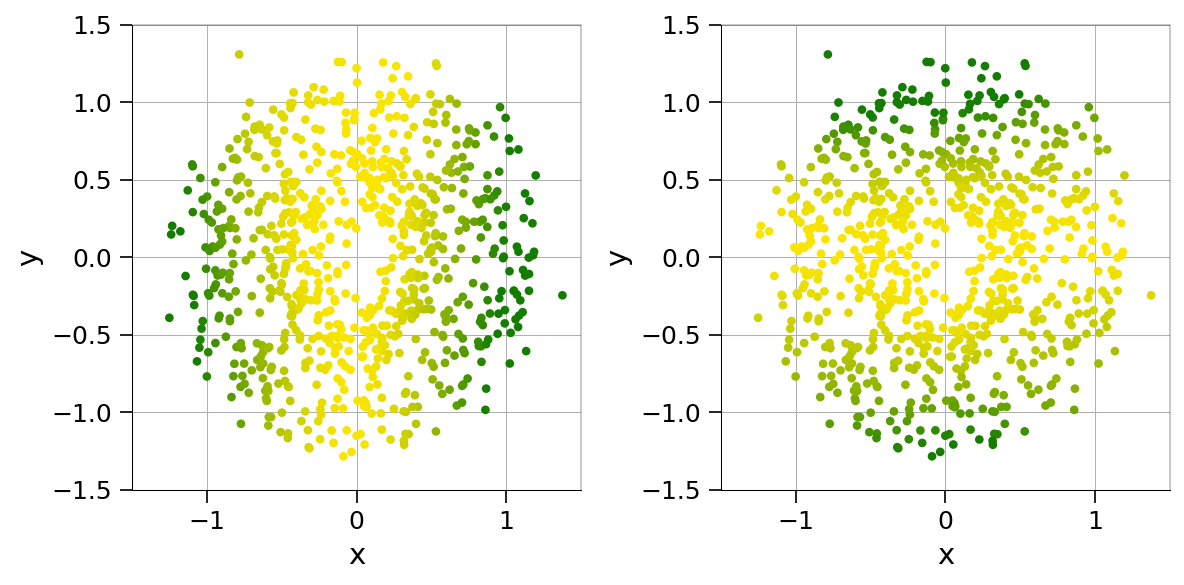

In [799]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plot_axis(ax=axs[0], x=x_train[:, 0], y=x_train[:, 1], c=softplus_attributions[:, 0], s=10)
plot_axis(ax=axs[1], x=x_train[:, 0], y=x_train[:, 1], c=softplus_attributions[:, 1], s=10)
fig.tight_layout()

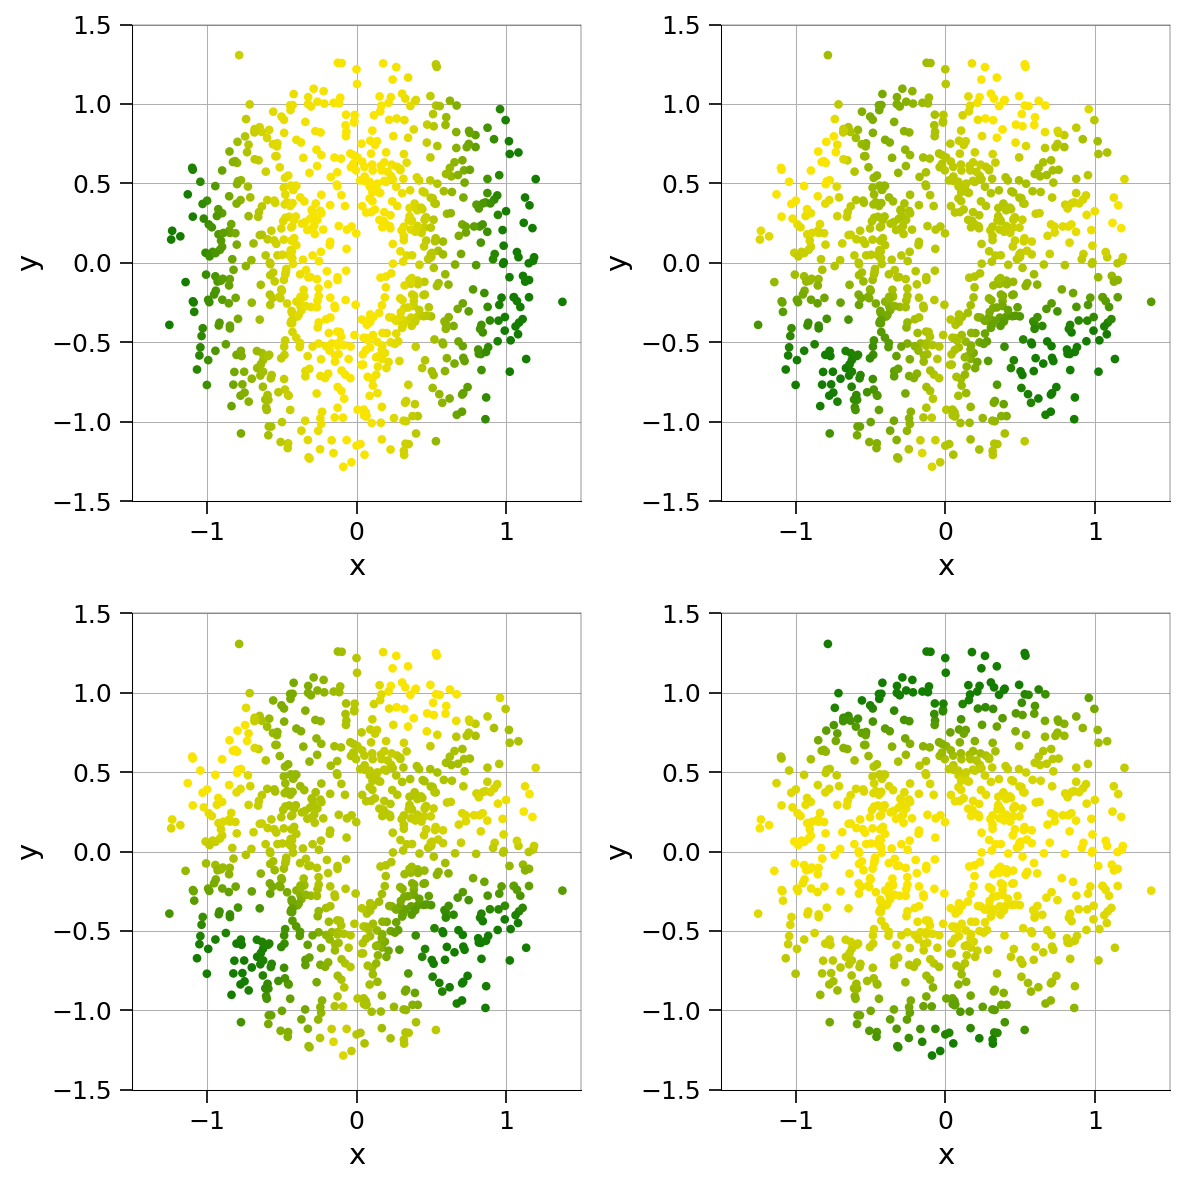

In [800]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plot_axis(ax=axs[0, 0], x=x_train[:, 0], y=x_train[:, 1], c=softplus_interactions[:, 0, 0], s=10)
plot_axis(ax=axs[0, 1], x=x_train[:, 0], y=x_train[:, 1], c=softplus_interactions[:, 0, 1], s=10)
plot_axis(ax=axs[1, 0], x=x_train[:, 0], y=x_train[:, 1], c=softplus_interactions[:, 1, 0], s=10)
plot_axis(ax=axs[1, 1], x=x_train[:, 0], y=x_train[:, 1], c=softplus_interactions[:, 1, 1], s=10)
fig.tight_layout()

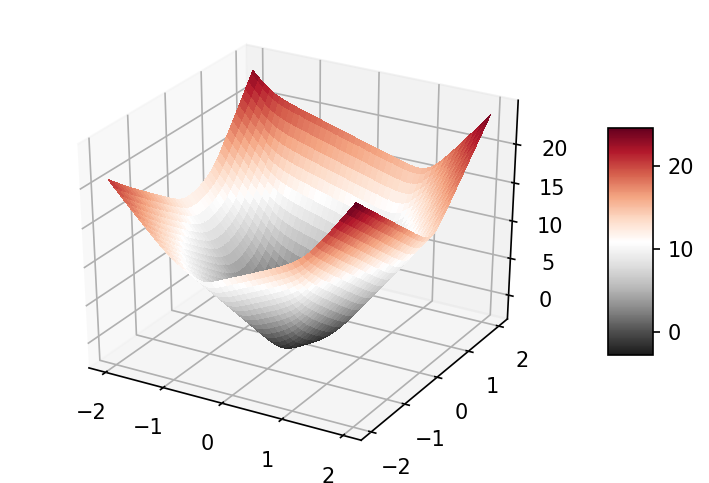

In [811]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, softplus_Z, cmap='RdGy_r',
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)